# Data Processing

## Imports

In [10]:
import os
import sys
sys.path.insert(0, '/home/hadivafa/Dropbox/git/A1ToneDiscrimination/')
from utils.process import *
from utils.plot_functions import mk_pie_plot, mk_data_summary_plot

import numpy as np
import pandas as pd
from os.path import join as pjoin
from copy import deepcopy as dc
from tqdm.notebook import tqdm
import pickle
import h5py

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

### Data dir

In [2]:
base_dir = pjoin(os.environ['HOME'], 'Documents/Kanold')
data_dir = pjoin(base_dir, 'Data')
results_dir = pjoin(base_dir, 'results')

## Organize data

Get raw data and organize it in python h5 files.  Data processing:

- First step was to remove traces that contained NaN.  This sometimes meant removing entire trials that had NaN for all neurons in the experiment, and sometime meant removing neurons that had NaN in all their trials.
- Next step was to identify and remove outlier neurons.

In [3]:
nb_std = 1
organize_data(base_dir, nb_std=nb_std)

[INFO] file found. exiting...




## Print data summary

In [4]:
processed_dir = pjoin(base_dir, 'python_processed')
h_load_file = pjoin(processed_dir, "organized_nb_std={:d}.h5".format(nb_std))

summary_data = summarize_data(h_load_file)

*** Data Summary ***
---------------------------------------------
- num experiments: 34,
- num animals: 9,
- num good cells: 2457,    
- num behavior trials 3953,
- num passive trials 1839,    

- num/percent different trials:
	○ target: 1983 (50%)
	○ nontarget: 1970 (50%)
	○ correctreject: 1411 (36%)
	○ hit: 1180 (30%)
	○ earlyhit: 411 (10%)
	○ falsealarm: 329 (8%)
	○ miss: 295 (7%)
	○ early: 199 (5%)
	○ earlyfalsealarm: 123 (3%)

- percent frequencies used (behavior):
	○ 9899 Hz: 26%
	○ 7000 Hz: 26%
	○ 19799 Hz: 25%
	○ 14000 Hz: 25%

- percent frequencies used (passive):
	○ 45255 Hz: 7%
	○ 22627 Hz: 7%
	○ 5657 Hz: 7%
	○ 8000 Hz: 7%
	○ 32000 Hz: 7%
	○ 11314 Hz: 7%
	○ 16000 Hz: 7%
	○ 4000 Hz: 7%
	○ 56569 Hz: 6%
	○ 5000 Hz: 6%
	○ 7071 Hz: 6%
	○ 28284 Hz: 6%
	○ 10000 Hz: 6%
	○ 20000 Hz: 6%
	○ 14142 Hz: 6%
	○ 40000 Hz: 6%

- percent stim levels used (behavior):
	○ 75 dB: 77%
	○ 70 dB: 11%
	○ 55 dB: 8%
	○ 60 dB: 5%

- percent stim levels used (passive):
	○ 75 dB: 46%
	○ 64 dB: 35%
	○ 55 d

### Pie chart as a visual summary

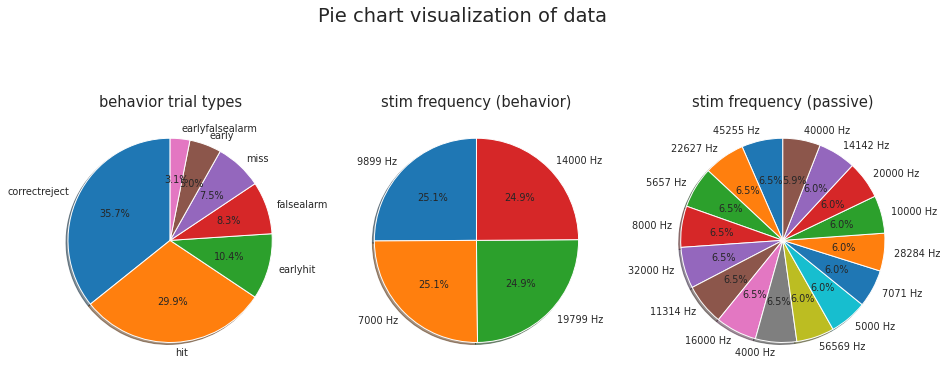

In [5]:
_ = mk_pie_plot(
    summary_data,
    figsize=(16, 7),
    dpi=70,
)

### Outlier removal

To ensure results are not corrupted by noisy samples, I identify a small subset of neurons as outliers and remove them.  To detect these neurons, I calculated the $p$-norm for 2 values of $p = 2$ and $p = \inf$.   Then removed neurons with a norm that was $n_{std} = 1$ std away from the mean norm.  I think what Manasij did was similar to $p = \inf$ case.  I decided to use $p = 2$ instead since the end result didn’t really change.  Here is percentage of neurons removed depending on the threshold:

- **1 std:   8.92 % removed**
- 2 std:   4.68 % removed
- 3 std:   2.37 % removed
- 5 std:   0.77% removed

This figure compares an example outlier neuron's trace to other neurons form the same experiment/trial.

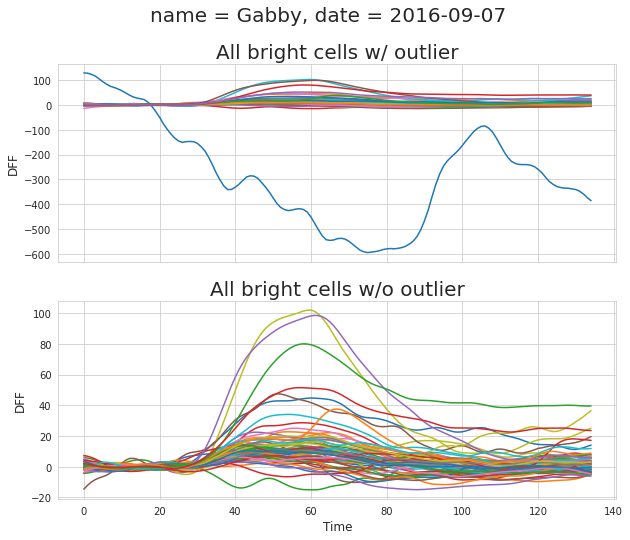

In [6]:
from pathlib import Path
data_dir = pjoin(base_dir, 'Data')

for path in Path(data_dir).rglob('*.pkl'):
    file = str(path)
    data = pickle.load(open(file, "rb"))
    if data[0]['name'] == "Gabby" and data[0]['date'] == "2016-09-07":
        break

bright_cells = data[0]['bright_cells']
hit = data[0]['hit']
dff = data[0]['dff']

dff = dff[..., bright_cells == 1][:, hit == 1, :]

sns.set_style('whitegrid')
fig, ax_arr = plt.subplots(2, 1, figsize=(10, 8), sharex='col')

ax_arr[0].plot(dff.mean(1))
ax_arr[0].set_ylabel("DFF", fontsize=12)
ax_arr[0].set_title("All bright cells w/ outlier", fontsize=20)

ax_arr[1].plot(dff[..., 1:].mean(1))
ax_arr[1].set_xlabel("Time", fontsize=12)
ax_arr[1].set_ylabel("DFF", fontsize=12)
ax_arr[1].set_title("All bright cells w/o outlier", fontsize=20)

plt.suptitle("name = {}, date = {}".format(data[0]['name'], data[0]['date']), fontsize=20)
plt.show()

## Plot average traces, licks etc

load the data

In [7]:
from utils.generic_utils import reset_df

load_dir = pjoin(processed_dir, "processed_nb_std={:d}".format(nb_std))
df_all = []
for file_name in tqdm(os.listdir(load_dir)):
    with open(pjoin(load_dir, file_name)) as f:
        df = pd.read_pickle(f.name)
        df_all.append(df)
df_all = pd.concat(df_all)
df_all = reset_df(df_all)

### Figure description

- top row shows average traces across neurons for given trial types. each subplot inclues:
    - avg **EXC** response (cells that on average were excited during that trial)
    - avg **SUP** response (cells that on average were suppressed during that trial)
    - avg overall
- 2nd row shows the distribution of EXC/SUP cells for each trial type
- last row shows avg of the largest activation for EXC and SUP across trial types (if data were zscored, this plot would be more or les flat)

#### Using one experiment (avg across cells just for this experiment)

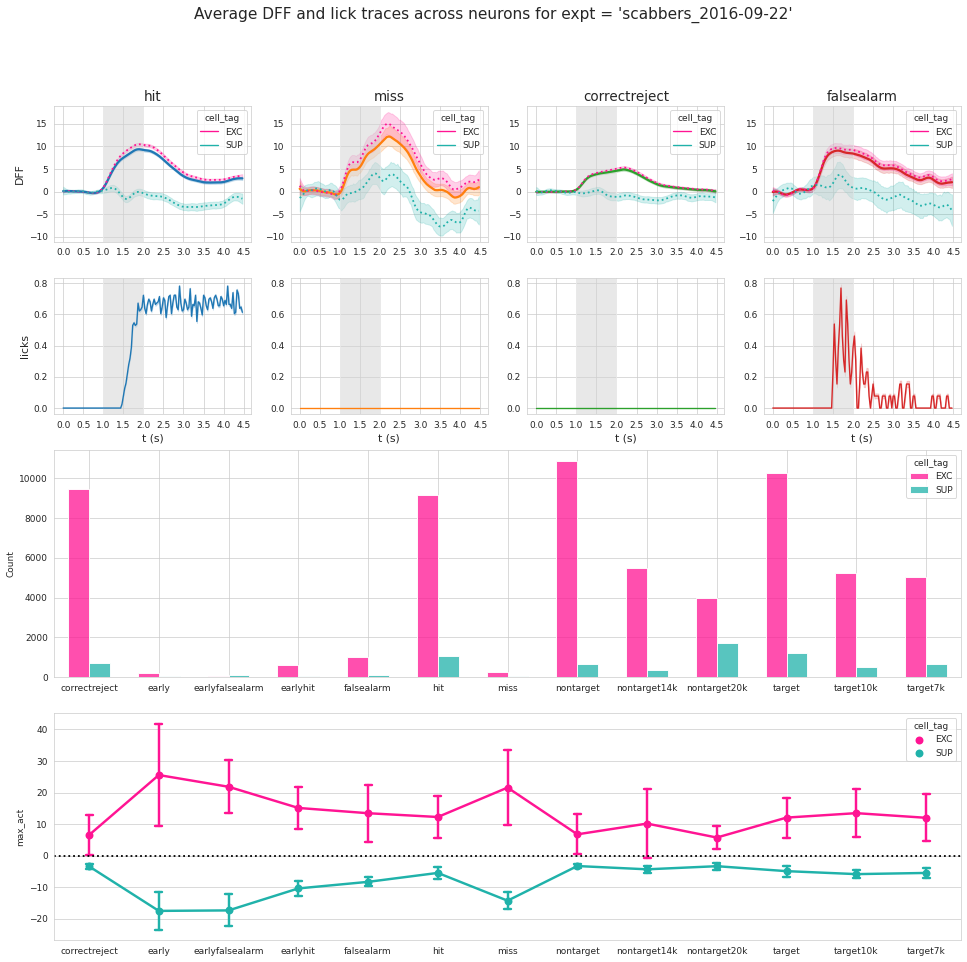

In [11]:
name = 'scabbers_2016-09-22'
selected_df = df_all.loc[df_all.name == name]

_ = mk_data_summary_plot(
    df=selected_df,
    figsize=(18, 17),
    dpi=65,
)

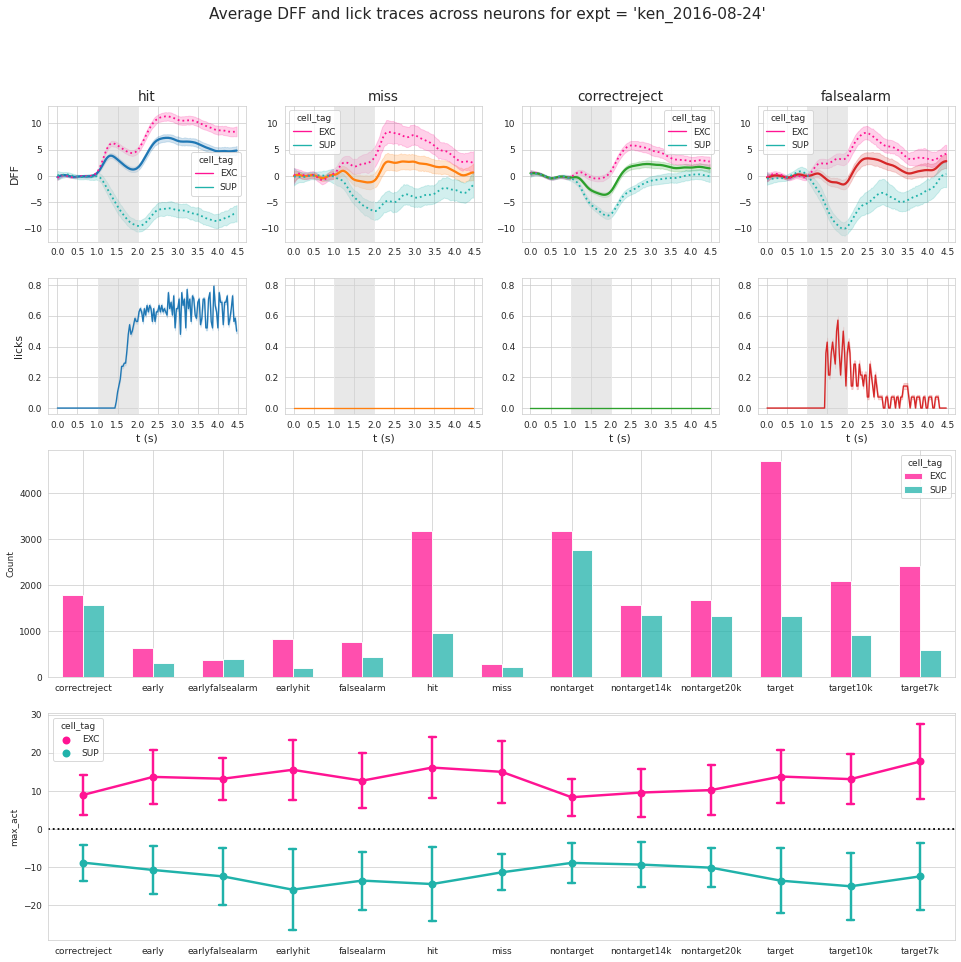

In [18]:
name = 'ken_2016-08-24'
selected_df = df_all.loc[df_all.name == name]

_ = mk_data_summary_plot(
    df=selected_df,
    figsize=(18, 17),
    dpi=65,
)

#### Observartions:
- EXC/SUP distribution can be different for different experiments
    - Usually EXC is statistically much more present (in all trials, to a varying extent)
    - but sometimes there are cases where SUP dominates over EXC
- This is most likely the result of heavy training, for example, in the 2nd figure above (corresponding to 'ken_2016-08-24') we see that almost half the neurons are suppressed during nontarget trials, but this is not the case for the first example, 'scabbers_2016-09-22'

Now let us look at the average statistics across all experiments and trials:

#### Global avg

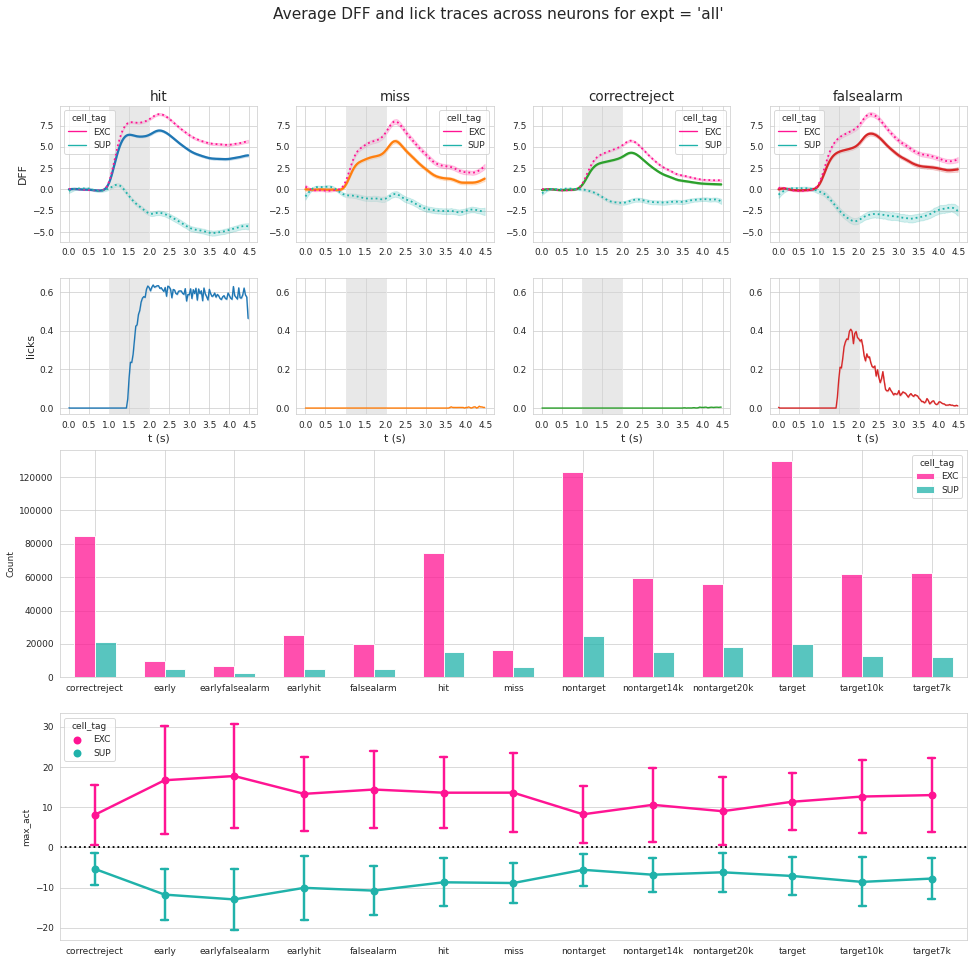

In [12]:
_ = mk_data_summary_plot(
    df=df_all,
    figsize=(18, 17),
    dpi=65,
)

## Simply looking at averages might be misleading
There are cells that respond consistently across trials for the same trial type, but most cells have varying responses.  For example, figure below shows responses of an example cell from **rodger_2017-08-20** experiment during **hit** trials.  As we can see from the figure, the cell is higly responsive in roughly half of these trials and not very responsive for the rest. 

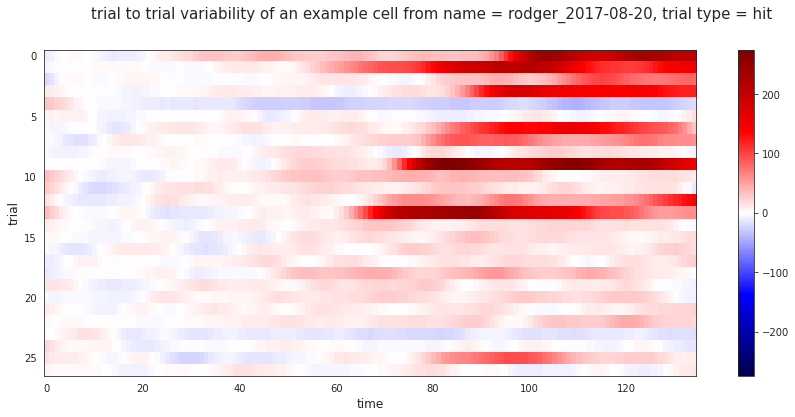

In [17]:
nt = 135
name = "rodger_2017-08-20"
trial_type = 'hit'

selected_df = df_all.loc[(df_all.name == name) & (df_all.trial == trial_type)]
nc = len(selected_df.cell_indx.unique())
ntrials = int(len(selected_df) / nc / nt)

dff = selected_df.dff.to_numpy().reshape(nt, ntrials, nc)

cindx = 40
data_to_plot = dff[:, :, cindx].T
vminmax = np.max(abs(data_to_plot))

sns.set_style('white')
plt.figure(figsize=(15, 6))
plt.imshow(data_to_plot, cmap='seismic', aspect=0.5 * data_to_plot.shape[-1] / data_to_plot.shape[0],
           vmin=-abs(vminmax), vmax=abs(vminmax))
plt.xlabel('time', fontsize=12)
plt.ylabel('trial', fontsize=12)
msg = 'trial to trial variability of an example cell from name = {}, trial type = {}'
msg = msg.format(name, trial_type)
plt.suptitle(msg, fontsize=15)
plt.colorbar()
plt.show()